In [1]:
%matplotlib inline
import pandas as pd
from astroquery.mast import Catalogs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#eventually put these into another .py file to create final targets lists

import math as m

# unique item finder

def uniquefinder(mylist):
    '''
    Function finds unique values within a list, also stats on occurance rates
    
    inputs: an array or list 
            (integers or strings)
    2 outputs: dictionary of occurances, list of unique values 
    '''
    seen = {}
    dupes = []
    uniq_tics = []
    for x in mylist:
        if x not in seen:
            seen[x] = 1
            uniq_tics.append(x)
        else:
            if seen[x] == 1:
                dupes.append(x)
            seen[x] += 1
    uniques = len(uniq_tics)
    #print('There are {} unique tics out of the original {}.'.format(uniques,len(mylist)),\
    #    '\nUse the first output dictionary', \
    #      'to see number of occurances for duplicates')
    return seen, uniq_tics


#useful fcn - compares lists & returns what didnt match
def returnNotMatches(a, b):
    '''
    inputs: a,b
            both lists or arrays
    outputs: not in b, not in a
            two lists
    '''
    return [[x for x in a if x not in b], [x for x in b if x not in a]] #not in b , not in a


def find_range(x, axis=0):
    '''
    ~Finds range of an array/list using max - min values; use with positive value data only~
    REQUIRES: numpy
    Args:
          x    -(list or array)
    Returns:
          integer value of range
    '''
    return np.max(x, axis=axis) - np.min(x, axis=axis)


def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return m.floor(n * multiplier) / multiplier


def round_up(n, decimals=0): 
    multiplier = 10 ** decimals 
    return m.ceil(n * multiplier) / multiplier


# based on training set
def label_meanings(label):
    ''' 
    1== Periodic = "very clear periodicity in light curve"; 
    2==Complex = "clear periodicity but complicated by multiple spots or low signal to noise";
    3== EB = "eclipsing binaries"; 
    4==Binaries = "likely eclipsing binaries too"; 
    5==Flat = "no rotational modulation"
    '''
    mydictionary = {1:'Astrophysical Signal',3:'Likely Eclipsing Binary',5:'Flat',2:'nothing',4:'nothing'}
    return(mydictionary[label])

def abs_mag(m,D):
    '''
    ~converts apparent mag to absolute mag~
    args:
          m: apparent mag
          D: 1/parallax in parsecs
    RETURNS: absolute mag
    '''
    return m - 5*np.log10(D) + 5

def mas_to_arcsec(mas):
    '''
    ~converts milliarcseconds(mas) to arcseconds, useful b/c Gaia parallax in mas~
    args:
         mas: parallax measure in mas
    RETURNS: parallax in arcseconds
    '''
    return mas / 1000

def get_D(parallax):
    '''
    ~converts parallax to distance~
    args:
        parrallax: parallax measure in mas units
    RETURNS: distance in parsecs
    '''
    plx = mas_to_arcsec(parallax)
    return 1/plx

def slope(x1,x2,y1,y2):
    ''' 
    ~takes input coordinates of 2 points to determine slope of line~
    inputs: coordinates for 2 plotted datapoints
    returns: slope
    '''
    m = (y2 -y1) / (x2-x1)
    return (y2 -y1) / (x2-x1)

def get_b(m,x,y):
    '''
    ~gives y-intercept(b) for a straight line~
    inputs: slope(m); point on line(x,y)
    returns: b
    '''
    b = -(m*x) + y
    return b

# Opening data / get sample origin stats

In [3]:
#opening all sector target lists into one list

pathstart = '/Volumes/Seagate-stars/PAPER_FINAL_FILES/target_lists/full_target_lists_with_giants/'
target_fns = 'all_targets_S0{}_v1.csv'#.format(01) change per sector number 01-26
all_targetslists_1 = []

for i in range(1,27):
    small = np.arange(1,10,1)
    #format file names correctly
    if np.isin(i,small)==True:
        si = '0' + str(i)
    else:
        si = str(i)
    name = pathstart + target_fns.format(si)
    targets = pd.read_csv(name,skiprows=5) #open data
    print('Sector {} has {} 2-minute targets.'.format(i,len(targets)))
    all_targetslists_1.append(targets['TICID'].to_numpy()) #list of lists
all_targetslists_2 = np.concatenate(all_targetslists_1)
all_targetslists = np.unique(all_targetslists_2)
print('\nTotal of {} unique targets in {} full sectors (1-26).'.format(len(all_targetslists),len(all_targetslists_1)))
print('Total of {} light curves in {} full sectors (1-26)'.format(len(all_targetslists_2), len(all_targetslists_1)))
# There are 487898 total targets from NCVZ, SCVZ, and sectors 14 & 15----light curves

Sector 1 has 15899 2-minute targets.
Sector 2 has 16000 2-minute targets.
Sector 3 has 16000 2-minute targets.
Sector 4 has 20000 2-minute targets.
Sector 5 has 20000 2-minute targets.
Sector 6 has 20000 2-minute targets.
Sector 7 has 20000 2-minute targets.
Sector 8 has 20000 2-minute targets.
Sector 9 has 20000 2-minute targets.
Sector 10 has 20000 2-minute targets.
Sector 11 has 20000 2-minute targets.
Sector 12 has 20000 2-minute targets.
Sector 13 has 20000 2-minute targets.
Sector 14 has 20000 2-minute targets.
Sector 15 has 20000 2-minute targets.
Sector 16 has 20000 2-minute targets.
Sector 17 has 20000 2-minute targets.
Sector 18 has 20000 2-minute targets.
Sector 19 has 20000 2-minute targets.
Sector 20 has 20000 2-minute targets.
Sector 21 has 20000 2-minute targets.
Sector 22 has 20000 2-minute targets.
Sector 23 has 20000 2-minute targets.
Sector 24 has 19999 2-minute targets.
Sector 25 has 20000 2-minute targets.
Sector 26 has 20000 2-minute targets.

Total of 232764 uniq

In [4]:
## get numbers for target locations

print('Reduced target lists to only N/S-CVZ regions & full sectors for 14 and 15:')
##isolate SCVZ from all South targets
#open south target lists
full_south = []
for i in range(1,14):
    small = np.arange(1,10,1)
    #format file names correctly
    if np.isin(i,small)==True:
        si = '0' + str(i)
    else:
        si = str(i)
    name = pathstart + target_fns.format(si)
    targets = pd.read_csv(name,skiprows=5) #open data
    full_south.append(targets['TICID'].to_numpy()) #list of lists    
#check for repeated tics across all south sectors
full_south2 = np.concatenate(full_south) #make into one list
dupes, solos = uniquefinder(full_south2) #this prints a stmt automatically
scvz = []; scvz_lcs = []
for i in dupes.keys(): #keys = tic; value = number of occurances
    if dupes[i] >=10:
        scvz.append(i)
        scvz_lcs.append(dupes[i])
    else:
        pass
print('\nThere are {} unique SCVZ targets - SCVZ have 10+sectors available'.format(len(scvz)))


##isolate NCVZ from all North targets
#open south target lists
full_north = []
for i in range(13,27):
    name = pathstart + target_fns.format(i)
    targets = pd.read_csv(name,skiprows=5) #open data
    full_north.append(targets['TICID'].to_numpy()) #list of lists    
#check for repeated tics across all south sectors
full_north2 = np.concatenate(full_north) #make into one list
dupes, solos = uniquefinder(full_north2) #this prints a stmt automatically
ncvz = []; ncvz_lcs = []
for i in dupes.keys(): #keys = tic; value = number of occurances
    if dupes[i] >=10:
        ncvz.append(i)
        ncvz_lcs.append(dupes[i])
    else:
        pass
print('There are {} unique NCVZ targets - NCVZ have 10+sectors available'.format(len(ncvz)))


##combine sectors 14 & 15 into one target list
#open sec 14 & 15 target lists
bothsecs = []
for i in range(14,16):
    name = pathstart + target_fns.format(i)
    targets = pd.read_csv(name,skiprows=5) #open data
    bothsecs.append(targets['TICID'].to_numpy()) #list of lists
#check for repeated tics across all south sectors
bothsecs2 = np.concatenate(bothsecs) #make into one list
secs1415 = np.unique(bothsecs2) 
print('\nThere are {} unique targets in sectors 14 & 15'.format(len(secs1415)))


## combine 14,15, NCVZ, SCVZ into one list to remove giants before download data
all_targetslists1 = np.concatenate([secs1415,ncvz,scvz])
all_targetslists = np.unique(all_targetslists1) #b/c 14,15 overlap NCVZ
print('{} unique targets from sectors 14 & 15 are also NCVZ stars'.format(len(all_targetslists1)-len(all_targetslists)))
print('\nThere are a total of {} unique targets AFTER isolating N/S-CVZs and Secs 14 15 but BEFORE teff cut & giant removal'.format(len(all_targetslists)))
all_lcs_beforetgcuts = np.sum(ncvz_lcs)+ np.sum(scvz_lcs) + len(bothsecs2)
print('with {} total light curves'.format(all_lcs_beforetgcuts))
print('\nThere are {} light curves from NCVZ'.format(np.sum(ncvz_lcs)))
print('There are {} light curves from SCVZ'.format(np.sum(scvz_lcs)))
print('There are {} light curves from sectors 14 & 15'.format(len(bothsecs2)))





Reduced target lists to only N/S-CVZ regions & full sectors for 14 and 15:

There are 6010 unique SCVZ targets - SCVZ have 10+sectors available
There are 7162 unique NCVZ targets - NCVZ have 10+sectors available

There are 27906 unique targets in sectors 14 & 15
7067 unique targets from sectors 14 & 15 are also NCVZ stars

There are a total of 34011 unique targets AFTER isolating N/S-CVZs and Secs 14 15 but BEFORE teff cut & giant removal
with 196372 total light curves

There are 85302 light curves from NCVZ
There are 71070 light curves from SCVZ
There are 40000 light curves from sectors 14 & 15


# Teff cut 

In [5]:
#teff cut

#get tic catalog
catalog_data = Catalogs.query_criteria(catalog='Tic',ID=all_targetslists) #get tic catalog
catalog_df1 = catalog_data.to_pandas()#change astropy table to pandas df
#do teff cut
catalog_df = catalog_df1[catalog_df1['Teff']<=6500]
catalog_df = catalog_df.reset_index(drop=True) #need this to cycle thru comparevalues later
print('Teff cut keeps stars <= 6500 K')
print('\nTotal of {} unique targets CUT in teff cut'.format(len(catalog_df1)-len(catalog_df)))
print('There are a total of {} unique target AFTER teff cut but BEFORE giants removal'.format(len(catalog_df)))

#see breakdown between groups
tc_ncvz = catalog_df[np.isin(catalog_df['ID'].to_numpy(int),ncvz)] #number of ncvz targets remaining
tc_scvz = catalog_df[np.isin(catalog_df['ID'].to_numpy(int),scvz)] #number of scvz targets remaining
tc_1415 = catalog_df[np.isin(catalog_df['ID'].to_numpy(int),secs1415)] #number of sec 14/15 targets remaining
post_teff1 = pd.concat([tc_ncvz,tc_scvz,tc_1415])
post_teff = np.unique(post_teff1['ID'].to_numpy(int))
tc_1415_ncvz = len(post_teff1)-len(post_teff) #number of sec14/15 that are ncvz targets remaining
print('\nSample Breakdowns: \nNCVZ targets post-teff cut: {}'.format(len(tc_ncvz)))
print('SCVZ targets post-teff cut: {}'.format(len(tc_scvz)))
print('Sec 14/15 targets post-teff cut: {}'.format(len(tc_1415)))
print('Sec 14/15 targets that are NCVZ, post-teff cut: {}'.format(tc_1415_ncvz))



/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'HIP' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'KIC' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'numcont' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'gaiaqflag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarnin

Teff cut keeps stars <= 6500 K

Total of 6386 unique targets CUT in teff cut
There are a total of 27625 unique target AFTER teff cut but BEFORE giants removal

Sample Breakdowns: 
NCVZ targets post-teff cut: 6019
SCVZ targets post-teff cut: 4734
Sec 14/15 targets post-teff cut: 22814
Sec 14/15 targets that are NCVZ, post-teff cut: 5942


# CMD plot

/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in log10


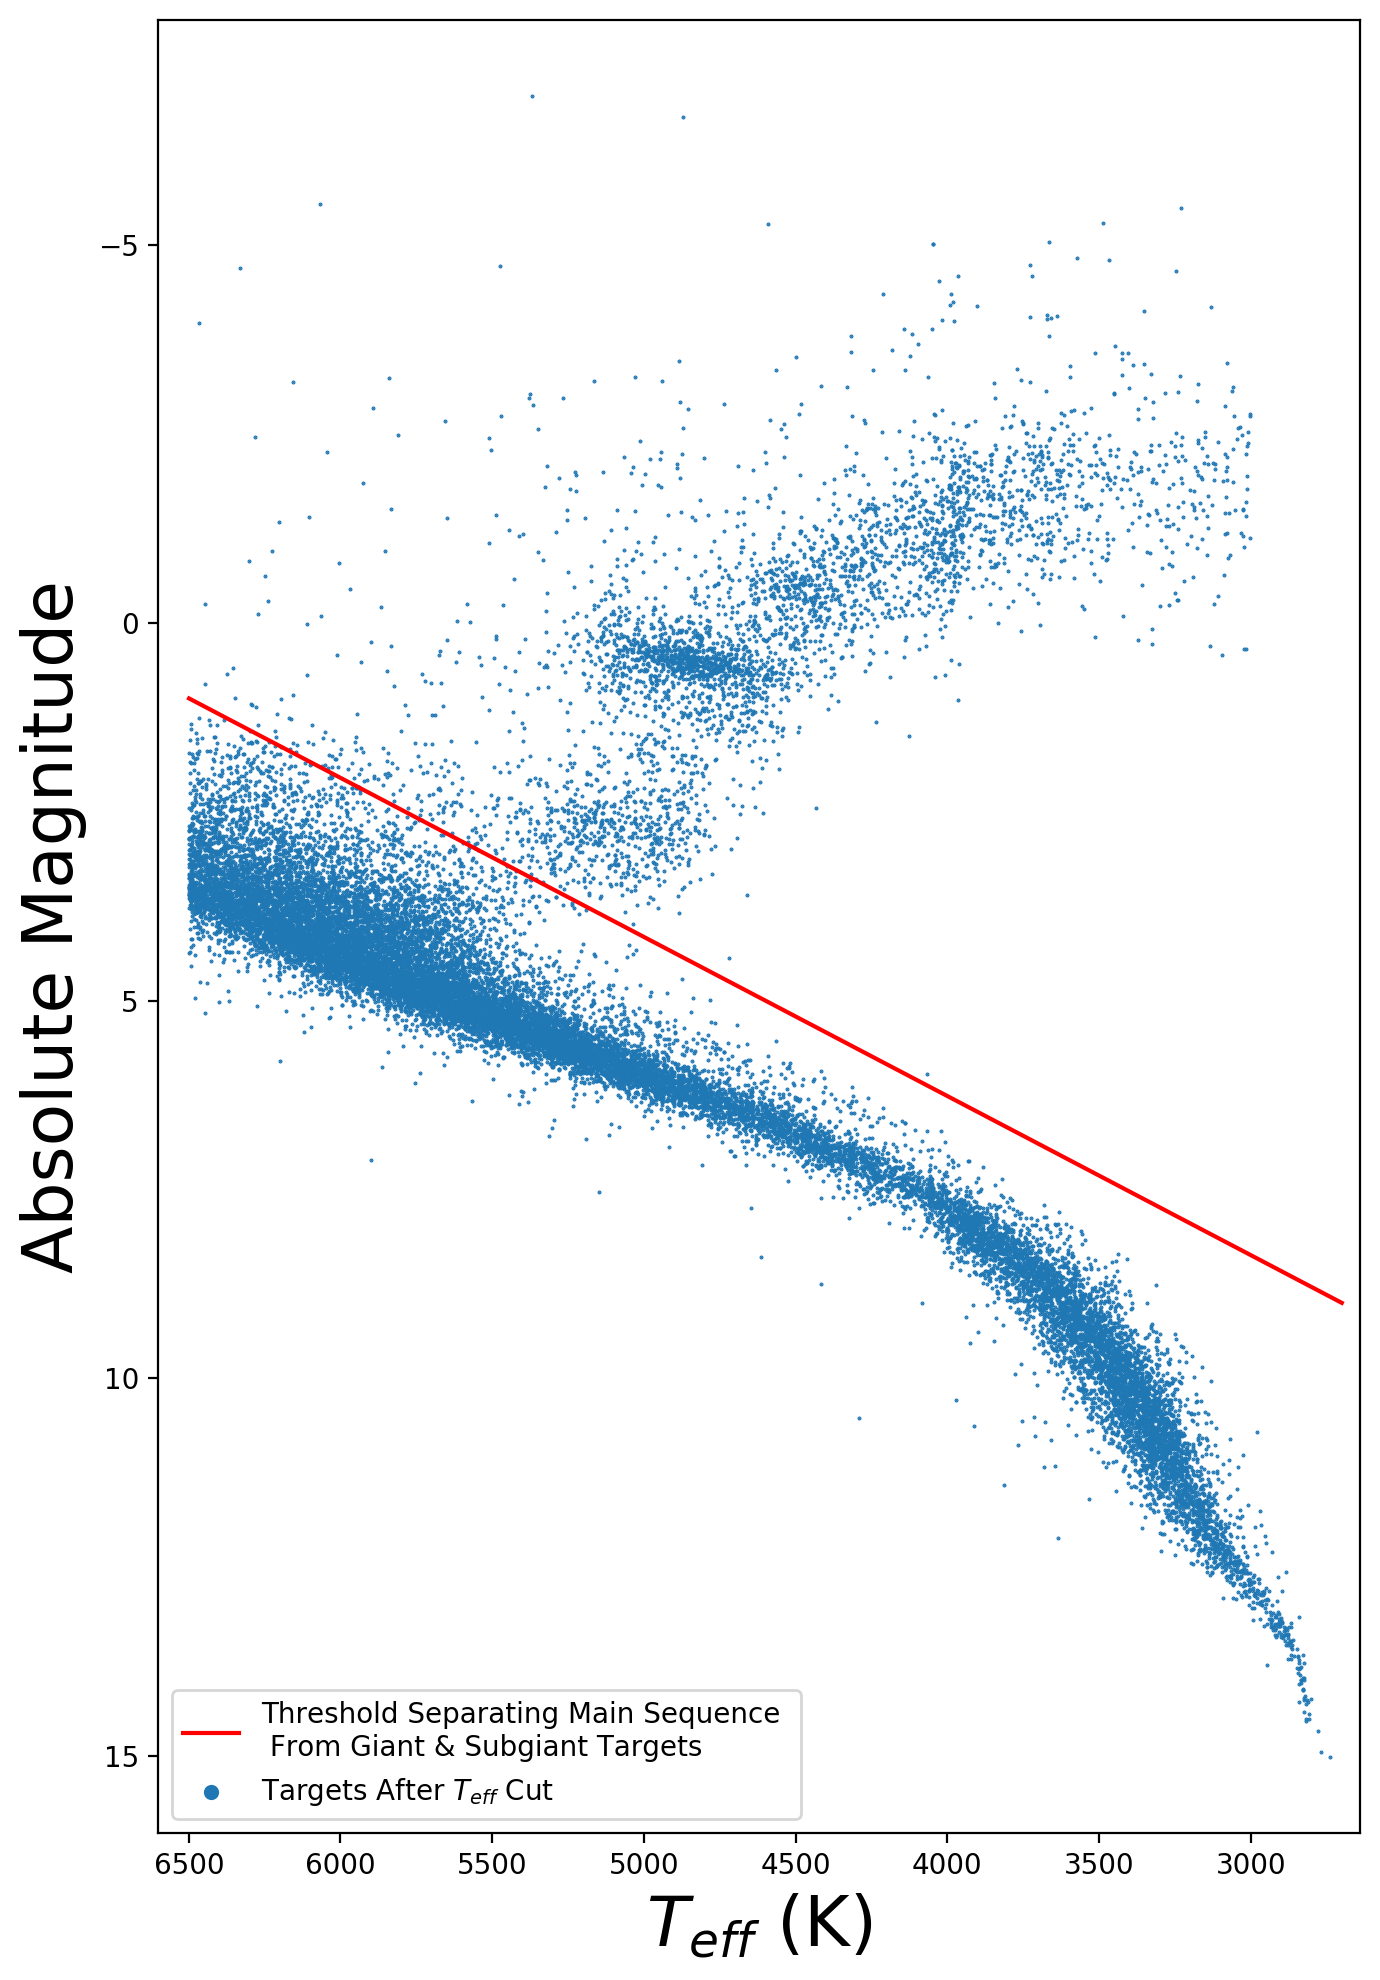

In [6]:
##convert m to M, create line separating populations, plot of cmd used in paper

#get ABS_mag
abs_GAIAmag = []
teffs =[]
for plx,mag,temp in catalog_df[['plx','GAIAmag','Teff']].to_numpy():
    D = get_D(plx)
    newmag=abs_mag(mag,D)
    abs_GAIAmag.append(newmag)
    teffs.append(temp)
#add to df
catalog_df['GAIA_AbsMag'] = abs_GAIAmag

#threshold line
pt1 = [6500,1] 
pt2 = [2700,9] 
m = slope(pt1[0],pt2[0],pt1[1],pt2[1])
b = get_b(m,pt1[0],pt1[1])
xarr = np.arange(pt2[0],pt1[0],1)
yarr = [m*x + b for x in xarr]

## plot
plt.figure(figsize=(7,10),dpi=200)
plt.scatter(teffs,abs_GAIAmag,s=.2,rasterized=True,label='Targets After $T_{eff}$ Cut')
plt.plot(xarr,yarr,color='r',label='Threshold Separating Main Sequence \n From Giant & Subgiant Targets')
plt.ylabel('Absolute Magnitude',fontsize=25);plt.xlabel('$T_{eff}$ (K)',fontsize=25);
plt.xlim(max(teffs)+100,min(teffs)-100)
plt.ylim(max(abs_GAIAmag)+1,min(abs_GAIAmag)-1);
plt.legend(markerscale=10,loc='lower left');
plt.tight_layout();

# plt.savefig('/Volumes/Seagate-stars/Final_Run/Plots/CMD.png') #already ran




# Giants /Subgiants Removal

22198 remain AFTER Teff cut & giant/subgiant removal


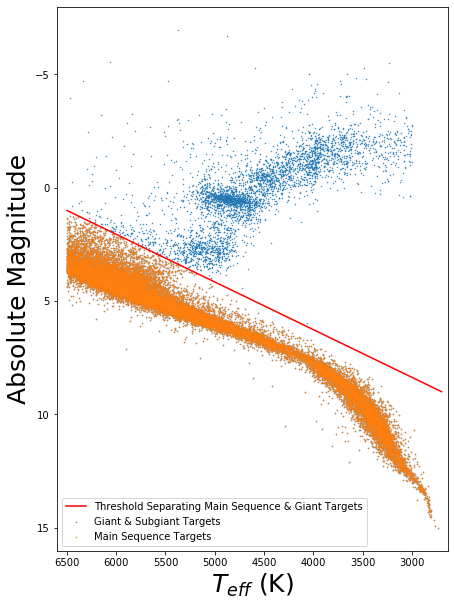

In [7]:
#additional figure to see stats after giant removal


#applying giant cut
#separate by comparison
compare_values = [m*x + b for x in catalog_df['Teff']] #ABSmagnitude value on the red line at star's teff
nogiants = catalog_df[[catalog_df['GAIA_AbsMag'][i] > compare_values[i] for i in range(len(compare_values))]]
giantsonly = catalog_df[[catalog_df['GAIA_AbsMag'][i] <= compare_values[i] for i in range(len(compare_values))]]

#isolate columns per group
nogiants_M = nogiants['GAIA_AbsMag'].to_numpy()
nogiants_temp = nogiants['Teff'].to_numpy()
giants_M = giantsonly['GAIA_AbsMag'].to_numpy()
giants_temp = giantsonly['Teff'].to_numpy()

## plot
plt.figure(figsize=(7,10))
plt.scatter(teffs,abs_GAIAmag,s=.2,label='Giant & Subgiant Targets')
plt.plot(xarr,yarr,color='r',label='Threshold Separating Main Sequence & Giant Targets')
plt.scatter(nogiants_temp,nogiants_M,s=.2,label='Main Sequence Targets' )
plt.ylabel('Absolute Magnitude',fontsize=25);plt.xlabel('$T_{eff}$ (K)',fontsize=25);
plt.xlim(max(teffs)+100,min(teffs)-100)
plt.ylim(max(abs_GAIAmag)+1,min(abs_GAIAmag)-1);
plt.legend();

#sample origin breakdowns
print('{} remain AFTER Teff cut & giant/subgiant removal'.format(len(nogiants_M)))




In [8]:
# applying giant cut

nogiants = nogiants.reset_index(drop=True)
gc_ncvz = nogiants[np.isin(nogiants['ID'].to_numpy(int),ncvz)] #number of ncvz targets remaining
gc_scvz = nogiants[np.isin(nogiants['ID'].to_numpy(int),scvz)] #number of scvz targets remaining
gc_1415 = nogiants[np.isin(nogiants['ID'].to_numpy(int),secs1415)] #number of sec 14/15 targets remaining
post_giants1 = pd.concat([gc_ncvz,gc_scvz,gc_1415])
post_giants = np.unique(post_giants1['ID'].to_numpy(int))
gc_1415_ncvz = len(post_giants1)-len(post_giants) #number of sec14/15 that are ncvz targets remaining

print('\nTotal of {} unique targets CUT in giants cut'.format(len(catalog_df)-len(nogiants)))
print('There are a total of {} unique target AFTER teff cut & giants removal'.format(len(nogiants)))
print('\nSample Breakdowns: \nNCVZ targets post-giants cut: {}'.format(len(gc_ncvz)))
print('SCVZ targets post-giants cut: {}'.format(len(gc_scvz)))
print('Sec 14/15 targets post-giants cut: {}'.format(len(gc_1415)))
print('Sec 14/15 targets that are NCVZ, post-giants cut: {}'.format(gc_1415_ncvz))




Total of 5427 unique targets CUT in giants cut
There are a total of 22198 unique target AFTER teff cut & giants removal

Sample Breakdowns: 
NCVZ targets post-giants cut: 5250
SCVZ targets post-giants cut: 3837
Sec 14/15 targets post-giants cut: 18293
Sec 14/15 targets that are NCVZ, post-giants cut: 5182


In [9]:
# #see sample breakdown of light curves in final sample

#original lcs (no teff/giants cut, only n/s cvzs and 14 15)
all_lcs = np.concatenate([bothsecs2, full_south2, full_north2]) #includes ncvz/1415 overlap double counted
dupes, solos = uniquefinder(all_lcs)
#breakdown number lcs in each sample group
lcs_ncvz = np.sum([dupes[i] for i in gc_ncvz['ID'].to_numpy(int)])
lcs_scvz = np.sum([dupes[i] for i in gc_scvz['ID'].to_numpy(int)])
#figure out 1415 targets that are also ncvz stars
lcs_1415 = np.sum([dupes[i] for i in gc_1415['ID'].to_numpy(int)]) #INcludes cvz stars
common_ncvz_1415 = gc_1415.merge(gc_ncvz,on=['ID']) #overlap targets in cvz & 14/15
non_cvz_1415 = gc_1415[~gc_1415['ID'].isin(common_ncvz_1415['ID'])] #grab only 1415 NOT in cvz overlap
non_cvz_1415 =non_cvz_1415.reset_index(drop=True)
lcs_1415_non_cvz = np.sum([dupes[i] for i in non_cvz_1415['ID'].to_numpy(int)]) #EXcludes cvz stars
final_lcs = np.sum([lcs_ncvz,lcs_scvz,lcs_1415_non_cvz])

print('Final total number of unique targets is {}'.format(len(nogiants)))
print('Final total number light curves is {}'.format(final_lcs))
print('\nLight Curve Sample Breakdown:')
print('Final SCVZ lcs: {}'.format(lcs_scvz))
print('Final SCVZ targets: {}'.format(lcs_ncvz))
print('Final Sec 14/15 targets: {}'.format(lcs_1415))
print('Final Sec 14/15 targets that are NOT in NCVZ: {}'.format(lcs_1415_non_cvz))



Final total number of unique targets is 22198
Final total number light curves is 177992

Light Curve Sample Breakdown:
Final SCVZ lcs: 48952
Final SCVZ targets: 72268
Final Sec 14/15 targets: 128335
Final Sec 14/15 targets that are NOT in NCVZ: 56772


In [10]:
# save final target lists after cuts to begin downloading data----already ran

# savepath = '/Volumes/Seagate-stars/PAPER_FINAL_FILES/target_lists/'
# #all targets with ticatalog stats
# nogiants.to_csv('{}all_final_targets.csv'.format(savepath), index=False)
# #save tics of each group 
# np.save('{}targets_SCVZ.npy'.format(savepath), gc_scvz['ID'].to_numpy(int))
# np.save('{}targets_NCVZ.npy'.format(savepath), gc_ncvz['ID'].to_numpy(int))
# np.save('{}targets_Secs1415.npy'.format(savepath), gc_1415['ID'].to_numpy(int))
# np.save('{}targets_nonCVZ_Secs1415.npy'.format(savepath), non_cvz_1415['ID'].to_numpy(int))


# Use the _"all_final_targets"_ saved file to proceed to the _Download_Data_ Notebook (start @ step 3) to use MAST and make a curl script to download all available 2-min light curves, theres also a _create_curlscript.py_ file that can do this (b/c mast now has too much tess data to do ra/dec queries; >500,000) but it uses lightkurve and is very slow - but works!
